# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.587021,True,8.050700
1,1.154070,True,7.793740
2,1.497932,True,7.863156
3,0.928441,False,0.944806
4,0.427415,True,7.274739
...,...,...,...
995,3.071642,True,11.611381
996,0.298308,True,6.023494
997,1.897184,True,8.346324
998,0.547914,True,7.357157


<Axes: xlabel='v0'>

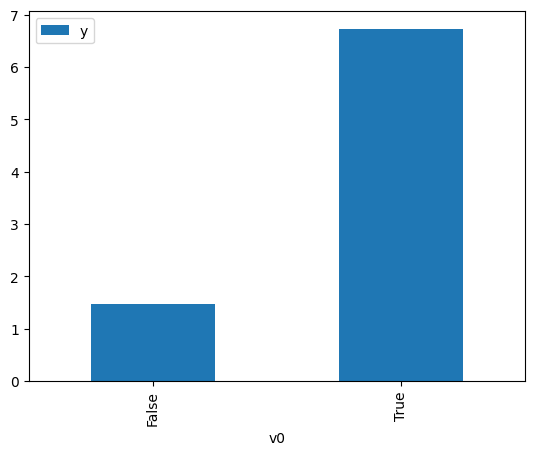

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

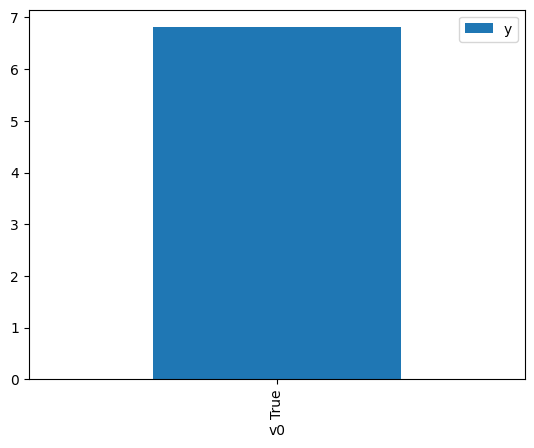

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.676976,False,2.402052,0.054852,18.230754
1,0.466361,False,2.198986,0.320444,3.120670
2,2.105714,False,2.985047,0.026893,37.184225
3,1.351740,False,1.681715,0.092467,10.814646
4,0.776988,False,-0.145643,0.215976,4.630139
...,...,...,...,...,...
995,1.475483,False,3.493019,0.075998,13.158301
996,-0.076713,False,0.111278,0.546875,1.828570
997,0.175184,False,1.568586,0.438352,2.281270
998,-0.337354,False,0.533776,0.654548,1.527771


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.582889,True,8.339768,0.936069,1.068298
1,1.005047,True,7.603354,0.843424,1.185644
2,1.375031,True,7.962805,0.910860,1.097864
3,1.738580,True,8.668073,0.950419,1.052167
4,2.016560,True,9.970678,0.968761,1.032247
...,...,...,...,...,...
995,1.521050,True,8.293903,0.929358,1.076012
996,0.547914,True,7.357157,0.709480,1.409483
997,1.005047,True,7.603354,0.843424,1.185644
998,-0.942411,True,2.495257,0.156284,6.398602


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                          2.192e+04
Date:                Tue, 21 Nov 2023   Prob (F-statistic):                        0.00
Time:                        17:09:55   Log-Likelihood:                         -1398.3
No. Observations:                1000   AIC:                                      2801.
Df Residuals:                     998   BIC:                                      2810.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8969      0.038     50.456      0.000       1.823       1.971
x2             5.1647      0.058     89.745      0.000       5.052       5.278
==============================================================================
Omnibus:                        0.986   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.611   Jarque-Bera (JB):                1.022
Skew:                           0.002   Prob(JB):                        0.600
Kurtosis:                       2.843   Cond. No.                         3.13
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""